# SPARK - DATAFRAMES 2

## CREAR SparkSession Y SparkContext

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, count_distinct, approx_count_distinct, max, min, sum, avg, collect_list, collect_set,  translate, locate, substring, initcap, lower, upper, trim, ltrim, rtrim, date_format, to_date, next_day, split, explode,  array_contains, size, sort_array, sum_distinct, year, last_day,dayofmonth, dayofyear, month, next_day, to_date, reverse, length, reverse, udf, round
from pyspark.sql import SparkSession
from pyspark.sql.types import  DoubleType
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

spark = (
    SparkSession.builder.master("local[*]").appName("pyspark_dataframe2").getOrCreate()
)
# spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/05 15:17:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = (
    spark.read.option("sep", ";")
    .option("header", "true")
    .option("inferSchema", "true")
    .csv("Datos/pdi_sales_small.csv")
)

## AGREGACIONES

Una vez tenemos un DataFrame, podemos realizar analítica de datos sobre el dataset entero, o sobre una o más columnas y aplicar una función de agregación que permita sumar, contar o calcular la media de cualquier grupo, entre otras opciones.

Para ello, PySpark ofrece un amplio conjunto de funciones. En nuestro caso, vamos a realizar algunos ejemplos para practicar con las funciones más empleadas.

### count
Devuelve la cantidad de elementos no nulos

In [3]:
df.select(count("Country")).show()

+--------------+
|count(Country)|
+--------------+
|        120239|
+--------------+



### count_distinct / countDistinct
Devuelve la cantidad de elementos no nulos diferentes

In [4]:
df.select(count_distinct("Country"), count_distinct("Zip")).show()

+-----------------------+-------------------+
|count(DISTINCT Country)|count(DISTINCT Zip)|
+-----------------------+-------------------+
|                      4|               2585|
+-----------------------+-------------------+



### approx_count_distinct / approxCountDistinct
Devuelve aproximadamente la cantidad de elementos no nulos diferentes (puede recibir un segundo parámetro la máxima desviación estándar admitida). Este método es mucho más rápido que contar exactamente, y para datasets muy grandes, en ocasiones puede ser útil

In [5]:
df.select(approx_count_distinct("Country"), approx_count_distinct("Zip")).show()

24/01/17 23:15:48 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------------------------+--------------------------+
|approx_count_distinct(Country)|approx_count_distinct(Zip)|
+------------------------------+--------------------------+
|                             4|                      2737|
+------------------------------+--------------------------+



### min y max
Permiten obtener el menor y el mayor valor respectivamente

In [6]:
df.select(min("Units"), max("Units")).show()

+----------+----------+
|min(Units)|max(Units)|
+----------+----------+
|         1|        77|
+----------+----------+



### sum
Permite sumar todos los valores de una columna

In [7]:
df.select(sum("Units"), sum("Revenue")).show()

+----------+-------------------+
|sum(Units)|       sum(Revenue)|
+----------+-------------------+
|    125728|5.010727499998837E7|
+----------+-------------------+



### sum_distinct y sumDistinct
Suma los valores diferentes de una columna

In [8]:
df.select(sum_distinct("Units"), sum_distinct("Revenue")).show()

+-------------------+---------------------+
|sum(DISTINCT Units)|sum(DISTINCT Revenue)|
+-------------------+---------------------+
|                308|    1189127.099999999|
+-------------------+---------------------+



### avg
Calcula la media aritmética

In [9]:
df.select(avg("Revenue"), sum("Revenue") / count("Revenue")).show()

+------------------+-------------------------------+
|      avg(Revenue)|(sum(Revenue) / count(Revenue))|
+------------------+-------------------------------+
|416.73063648224263|             416.73063648224263|
+------------------+-------------------------------+



### Asimetría, varianza y desviación típica
Si nos interesa obtener información estadística sobre los datos, también disponemos de las funciones skewness, kurtosis, variance, var_pop, stddev y stddev_pop.

### groupBy
Si agrupamos varias columnas de tipo categóricas (con una cardinalidad baja), podemos realizar cálculos sobre el resto de columnas.

Sobre un DataFrame, podemos agrupar los datos por la columna que queramos utilizando el método groupBy, el cual nos devuelve un GroupedData, sobre el que posteriormente realizar operaciones como avg(cols), count(), mean(cols), min(cols), max(cols) o sum(cols):

In [10]:
df.groupBy("Country").count().show()

+-------+-----+
|Country|count|
+-------+-----+
|Germany|30059|
|France |30060|
|Canada |30060|
|Mexico |30060|
+-------+-----+



In [11]:
df.groupBy("Country").sum("Revenue").show()

+-------+--------------------+
|Country|        sum(Revenue)|
+-------+--------------------+
|Germany|  1.49821199999994E7|
|France |1.2087942100000687E7|
|Canada |1.1642614200001836E7|
|Mexico |1.1394598700001087E7|
+-------+--------------------+



### agg

Si necesitamos realizar más de un agregación sobre el mismo grupo, mediante agg podemos indicar una o más expresiones de columnas:

In [12]:
df.groupBy("Country").agg(sum("Revenue"), count("Revenue")).show()

+-------+--------------------+--------------+
|Country|        sum(Revenue)|count(Revenue)|
+-------+--------------------+--------------+
|Germany|  1.49821199999994E7|         30059|
|France |1.2087942100000687E7|         30060|
|Canada |1.1642614200001836E7|         30060|
|Mexico |1.1394598700001087E7|         30060|
+-------+--------------------+--------------+



También podemos indicar los elementos a calcular mediante un diccionario donde las claves son los campos y los valores la función a calcular:

In [13]:
df.groupBy("Country").agg({"Zip": "count", "Revenue": "avg"}).show()

+-------+----------+------------------+
|Country|count(Zip)|      avg(Revenue)|
+-------+----------+------------------+
|Germany|     30059| 498.4237665923484|
|France |     30060|402.12714903528564|
|Canada |     30060|387.31251497012096|
|Mexico |     30060| 379.0618330007015|
+-------+----------+------------------+



### collect_list y collect_set
En ocasiones necesitamos agrupar en una colección todos los valores para un grupo en particular. Para ello, podemos usar collect_list (con repetidos) o collect_set (sin repeticiones):

Por ejemplo, para cada país, vamos a recuperar un listado con los códigos postales de aquellos pedidos que hayan superado las 5 unidades:

In [14]:
df.where("Units > 5").groupBy("Country").agg(
    collect_list("Zip"), collect_set("Zip")
).show()

+-------+--------------------+--------------------+
|Country|   collect_list(Zip)|    collect_set(Zip)|
+-------+--------------------+--------------------+
|Germany|[22397          ,...|[22111          ,...|
|France |[75213 CEDEX 16 ,...|[75391 CEDEX 08 ,...|
|Mexico |[7100           ,...|[10300          ,...|
|Canada |[T2X            ,...|[T6V            ,...|
+-------+--------------------+--------------------+



### pivot
Las tablas pivote permite obtener un resumen de los datos a partir de columnas categóricas sobre la que realizar cálculos, tal como se hace en las hojas de cálculo con las tablas dinámicas.

Por ejemplo, vamos a obtener la cantidad recaudada por las ventas de cada año por cada pais:

In [15]:
df = df.withColumn("Date", to_date(df.Date, "M/d/yyy"))
df.groupBy(year("Date")).pivot("Country").sum("Revenue").show()

+----------+------------------+------------------+-----------------+------------------+
|year(Date)|           Canada |           France |          Germany|           Mexico |
+----------+------------------+------------------+-----------------+------------------+
|      2003| 2360085.999999949|1105230.9000000039|1407119.999999999|1049457.4999999995|
|      2004| 1539140.499999946|              NULL|             NULL|              NULL|
|      2001| 2193437.799999908|              NULL|             NULL|233419.20000000004|
|      2000|1806678.3999999042|1108846.8999999764|4510606.799999929| 4240448.399999948|
|      1999|1382756.6999999755| 7594921.200000447|5928459.100000297|3419368.2000001906|
|      2002|2360514.7999998718| 2278943.099999955|3135934.099999969| 2451905.399999923|
+----------+------------------+------------------+-----------------+------------------+



También podemos hacer más de un cálculo sobre la tabla pivote:

In [16]:
df.groupBy(year("Date")).pivot("Country").agg(
    sum("Revenue").alias("total"), sum("Units").alias("cantidad")
).show()

+----------+------------------+----------------+------------------+----------------+-----------------+----------------+------------------+----------------+
|year(Date)|     Canada _total|Canada _cantidad|     France _total|France _cantidad|    Germany_total|Germany_cantidad|     Mexico _total|Mexico _cantidad|
+----------+------------------+----------------+------------------+----------------+-----------------+----------------+------------------+----------------+
|      2003| 2360085.999999949|            6375|1105230.9000000039|            2794|1407119.999999999|            3099|1049457.4999999995|            2510|
|      2004| 1539140.499999946|            3636|              NULL|            NULL|             NULL|            NULL|              NULL|            NULL|
|      2001| 2193437.799999908|            5976|              NULL|            NULL|             NULL|            NULL|233419.20000000004|             583|
|      2000|1806678.3999999042|            5049|1108846.89999997

## JOINS
Hasta ahora todo la analítica la hemos realizado sobre un único DataFrame, pero en ocasiones necesitamos cruzar la información de dos datasets.

![Tipos de joins](Datos/tipos_join.png)


Para los siguientes ejemplos, vamos a cambiar de datasets y utilizar datos de vuelos de avión que han tenido algún tipo de retraso (departure_delays.csv) y otro con los códigos de los aeropuertos (airport-codes-na.tsv).

In [17]:
df_vuelos = (
    spark.read.option("sep", ",")
    .option("header", "true")
    .option("inferSchema", "true")
    .csv("Datos/departure_delays.csv")
)

In [18]:
df_vuelos.printSchema()

root
 |-- date: integer (nullable = true)
 |-- delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- origin: string (nullable = true)
 |-- destination: string (nullable = true)



In [19]:
df_vuelos.count()

1391578

In [20]:
df_vuelos.show(5)

+-------+-----+--------+------+-----------+
|   date|delay|distance|origin|destination|
+-------+-----+--------+------+-----------+
|1011245|    6|     602|   ABE|        ATL|
|1020600|   -8|     369|   ABE|        DTW|
|1021245|   -2|     602|   ABE|        ATL|
|1020605|   -4|     602|   ABE|        ATL|
|1031245|   -4|     602|   ABE|        ATL|
+-------+-----+--------+------+-----------+
only showing top 5 rows



In [21]:
df_aeropuertos = (
    spark.read.option("sep", "\t")
    .option("header", "true")
    .option("inferSchema", "true")
    .csv("Datos/airport-codes-na.tsv")
)

In [22]:
df_aeropuertos.printSchema()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- IATA: string (nullable = true)



In [23]:
df_aeropuertos.count()

526

In [24]:
df_aeropuertos.show(5)

+----------+-----+-------+----+
|      City|State|Country|IATA|
+----------+-----+-------+----+
|Abbotsford|   BC| Canada| YXX|
|  Aberdeen|   SD|    USA| ABR|
|   Abilene|   TX|    USA| ABI|
|     Akron|   OH|    USA| CAK|
|   Alamosa|   CO|    USA| ALS|
+----------+-----+-------+----+
only showing top 5 rows



### Mediante SQL
Si queremos hacer un join mediante SQL, sólo tenemos que emplear la misma sintaxis que con cualquier sistema relacional, de manera que primero crearemos las vistas temporales:

In [25]:
df_vuelos.createOrReplaceTempView("vuelos")
df_aeropuertos.createOrReplaceTempView("aeropuertos")

Y a continuación realizamos la consulta:

In [26]:
df_join = spark.sql(
    "select v.origin, a.city from vuelos v join aeropuertos a on v.origin == a.IATA"
)
df_join.show(3)
df_join.count()

+------+---------+
|origin|     city|
+------+---------+
|   ABE|Allentown|
|   ABE|Allentown|
|   ABE|Allentown|
+------+---------+
only showing top 3 rows



1377162

Si quisiéramos obtener el nombre de los dos aeropuertos, necesitamos realizar dos veces el join:

In [27]:
df_join = spark.sql(
    "select v.*, a.City as originCity, b.City as destinationCity from vuelos v JOIN aeropuertos a on v.origin == a.IATA join aeropuertos b on v.destination = b.IATA"
)
df_join.show(3)
df_join.count()

+-------+-----+--------+------+-----------+----------+---------------+
|   date|delay|distance|origin|destination|originCity|destinationCity|
+-------+-----+--------+------+-----------+----------+---------------+
|1011245|    6|     602|   ABE|        ATL| Allentown|        Atlanta|
|1020600|   -8|     369|   ABE|        DTW| Allentown|        Detroit|
|1021245|   -2|     602|   ABE|        ATL| Allentown|        Atlanta|
+-------+-----+--------+------+-----------+----------+---------------+
only showing top 3 rows



1361141

Si existiera algún vuelo cuyos códigos de aeropuerto no tuviéramos disponible en el dataset de los códigos de aeropuertos, no nos aparecería. Por tanto, sería más conveniente realizar un left join:

In [28]:
df_left_join = spark.sql(
    "select v.*, a.City as originCity, b.City as destinationCity from vuelos v LEFT JOIN aeropuertos a on v.origin == a.IATA LEFT JOIN aeropuertos b on v.destination = b.IATA"
)
df_left_join.show(3)
df_left_join.count()

+-------+-----+--------+------+-----------+----------+---------------+
|   date|delay|distance|origin|destination|originCity|destinationCity|
+-------+-----+--------+------+-----------+----------+---------------+
|1011245|    6|     602|   ABE|        ATL| Allentown|        Atlanta|
|1020600|   -8|     369|   ABE|        DTW| Allentown|        Detroit|
|1021245|   -2|     602|   ABE|        ATL| Allentown|        Atlanta|
+-------+-----+--------+------+-----------+----------+---------------+
only showing top 3 rows



1391578

Además de los casos vistos, podemos realizar otros tipos de joins como cross, semi, full, outer, etc... 

Un caso particular que conviene conocer es el left anti join. Este tipo de join permite obtener aquellos registros de la izquierda que no aparecen en la parte derecha, de manera que si seguimos con el ejemplo, podemos recuperar aquellos vuelos cuyos aeropuertos no tenemos en el dataset con los códigos:

In [29]:
df_left_anti_join = spark.sql(
    "select * from vuelos v LEFT ANTI JOIN aeropuertos a ON v.origin == a.IATA "
)
df_left_anti_join.count() 

14416

### Mediante Python
El método join une dos DataFrames, indicando la expresión de unión y opcionalmente el tipo:

In [30]:
exprJoin1 = df_vuelos.origin == df_aeropuertos.IATA
df_joinp1 = df_vuelos.join(df_aeropuertos, exprJoin1, "inner")
df_joinp1.count() 

1377162

Si las columnas que unen los DataFrames tienen el mismo nombre, podemos simplificar el código indicando únicamente su nombre:


``````
df1.join(df2, "user_id")
``````
Además, si queremos hacer un inner join, podemos no indicarlo ya que es el tipo por defecto.

En vez de pasarle inner, le podemos indicar el tipo de join: left, right, cross, left_anti, etc...

In [31]:
expr_join1 = df_vuelos.origin == df_aeropuertos.IATA
df_left_anti_join = df_vuelos.join(df_aeropuertos, expr_join1, "left_anti")
df_left_anti_join.count() 

14416

Finalmente, como en nuestro caso teníamos dos joins, tanto para los vuelos de origen como los de destino, necesitamos volver a unir:

In [32]:
from pyspark.sql.functions import col

# le indicamos alias a los campos para eliminar ambigüedades
expr_join2 = col("a.destination") == col("b.IATA")
df_joinp2 = (df_joinp1.alias("a")).join(
    (df_aeropuertos.alias("b")), expr_join2, "inner"
)
df_joinp2.count()  # 1361141

1361141

## FUNCIONES

Para dominar realmente Spark, hay que tener destreza en todas las funciones existente para el tratamiento de fechas, cadenas, operaciones matemáticas, para trabajar con colecciones, etc...

Además, siempre podemos crear nuestras propias funciones de usuario para ampliar el lenguaje.

Aunque ya hemos utilizado algunas vamos a repasar las funciones más empleadas.

### FECHAS

* Convertir de texto a fecha: to_date, to_timestamp, unix_timestamp
* Formatear las fechas: date_format, from_unixtime (patrones de fechas)
* Realizar cálculos sobre fechas: datediff, months_between, last_day, date_add, date_sub, next_day
* Extraer un valor de una fecha: year, month, weekofyear, dayofmonth, dayofyear, hour, minute, second

In [33]:
df = df.withColumn("Date", to_date(df.Date, "M/d/yyy"))

df.select(
    "Date",
    date_format("Date", "dd-MM-yyy"),
    next_day("Date", "Sun"),
    last_day("Date"),
    dayofmonth("Date"),
    dayofyear("Date"),
    month("Date"),
    year("Date"),
).show(2)

+----------+----------------------------+-------------------+--------------+----------------+---------------+-----------+----------+
|      Date|date_format(Date, dd-MM-yyy)|next_day(Date, Sun)|last_day(Date)|dayofmonth(Date)|dayofyear(Date)|month(Date)|year(Date)|
+----------+----------------------------+-------------------+--------------+----------------+---------------+-----------+----------+
|1999-01-15|                  15-01-1999|         1999-01-17|    1999-01-31|              15|             15|          1|      1999|
|2002-06-06|                  06-06-2002|         2002-06-09|    2002-06-30|               6|            157|          6|      2002|
+----------+----------------------------+-------------------+--------------+----------------+---------------+-----------+----------+
only showing top 2 rows



### CADENAS

Por ejemplo, tenemos las funciones para quitar espacios (ltrim, rtrim, trim) y pasar a mayúsculas/minúsculas (lower, upper):

In [34]:
df.select(
    "Zip", ltrim("Zip").alias("l"), rtrim("Zip").alias("r"), lower("Zip"), upper("Zip")
).where(trim(df.Country) == "Canada").show(3)

+---------------+---------------+---+---------------+---------------+
|            Zip|              l|  r|     lower(Zip)|     upper(Zip)|
+---------------+---------------+---+---------------+---------------+
|H1B            |H1B            |H1B|h1b            |H1B            |
|H1B            |H1B            |H1B|h1b            |H1B            |
|H1B            |H1B            |H1B|h1b            |H1B            |
+---------------+---------------+---+---------------+---------------+
only showing top 3 rows



O funciones para poner la inicial en mayúsculas (initcap), darle la vuelta (reverse), obtener su tamaño (length) o reemplazar caracteres (translate):

In [35]:
df.select(
    "Country",
    initcap("Country"),
    reverse("Country"),
    length("Country"),
    translate("Country", "na", "pe"),
).where(trim(df.Country) == "Canada").show(1)

+-------+----------------+----------------+---------------+--------------------------+
|Country|initcap(Country)|reverse(Country)|length(Country)|translate(Country, na, pe)|
+-------+----------------+----------------+---------------+--------------------------+
|Canada |         Canada |          adanaC|              7|                   Cepede |
+-------+----------------+----------------+---------------+--------------------------+
only showing top 1 row



También podemos trabajar con subcadenas (substring), encontrar ocurrencias (locate) o partir una cadena en trozos (split):

In [36]:
df.select(
    "Country", split("Country", "a"), locate("a", "Country"), substring("Country", 3, 2)
).where(trim(df.Country) == "Canada").show(1)

+-------+---------------------+---------------------+------------------------+
|Country|split(Country, a, -1)|locate(a, Country, 1)|substring(Country, 3, 2)|
+-------+---------------------+---------------------+------------------------+
|Canada |         [C, n, d,  ]|                    2|                      na|
+-------+---------------------+---------------------+------------------------+
only showing top 1 row



Otras funciones que se suelen utilizar son concat y concat_ws para unir cadenas, levenshtein para calcular la distancia entre dos cadenas, lpad y rpad para completar con espacios, etc... Si necesitas trabajar con expresiones regulares puedes utilizar regexp_extract para extraer parte de una cadena o regexp_replace para sustituir.

### COLECCIONES
Para probar las funciones que trabajan con colecciones, vamos a cambiar de dataset y trabajar con uno compartido por Kaggle con datos de negocios de Yelp que tenemos almacenados en una versión reducida en yelp_academic_dataset_business.json. 

El primer paso es cargar el documento y ver el esquema leído por Spark:

In [37]:
dfYelp = (
    spark.read.option("inferSchema", "true")
    .option("multiline", False)
    .json("Datos/yelp_academic_dataset_business.json")
)

dfYelp.printSchema()

root
 |-- attributes: struct (nullable = true)
 |    |-- Accepts Credit Cards: string (nullable = true)
 |    |-- Accepts Insurance: boolean (nullable = true)
 |    |-- Ages Allowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: struct (nullable = true)
 |    |    |-- casual: boolean (nullable = true)
 |    |    |-- classy: boolean (nullable = true)
 |    |    |-- divey: boolean (nullable = true)
 |    |    |-- hipster: boolean (nullable = true)
 |    |    |-- intimate: boolean (nullable = true)
 |    |    |-- none: boolean (nullable = true)
 |    |    |-- romantic: boolean (nullable = true)
 |    |    |-- touristy: boolean (nullable = true)
 |    |    |-- trendy: boolean (nullable = true)
 |    |    |-- upscale: boolean (nullable = true)
 |    |-- Attire: string (nullable = true)
 |    |-- BYOB: boolean (nullable = true)
 |    |-- BYOB/Corkage: string (nullable = true)
 |    |-- By Appointment Only: boolean (nullable = true)
 |    |-- Caters:

Si nos fijamos podemos ver que los negocios tienen una propiedad denominada categories que contiene un array con las categorías de los mismos.

Vamos a ver mediante un ejemplo las siguientes funciones:

* size: devuelve el tamaño de la colección
* sort_array: ordena la colección
* array_contains: comprueba si hay un elemento en la colección

In [38]:
dfYelp.select(
    "name",
    "hours.Sunday",
    size("categories").alias("totalCategorias"),
    sort_array("categories").alias("categorias"),
    array_contains("categories", "Restaurants").alias("Restaurantes"),
).show(10, truncate=False)

+-------------------------------+--------------+---------------+---------------------------------------------------------------------------------+------------+
|name                           |Sunday        |totalCategorias|categorias                                                                       |Restaurantes|
+-------------------------------+--------------+---------------+---------------------------------------------------------------------------------+------------+
|Turf Paradise Race Course      |{18:00, 11:00}|4              |[Active Life, Arts & Entertainment, Horse Racing, Stadiums & Arenas]             |false       |
|Sam's Club Members Only        |NULL          |5              |[Automotive, Department Stores, Fashion, Shopping, Tires]                        |false       |
|Forever 21                     |{18:00, 11:00}|5              |[Accessories, Fashion, Men's Clothing, Shopping, Women's Clothing]               |false       |
|Loving Hands Pet Care          |{19:00,

Así pues, además del nombre, hemos obtenido el horario de los domingos utilizando la notación . para acceder a los campos anidados, la cantidad de categorías de cada comercio, un listado ordenado con sus categorías y finalmente si es un restaurante.

Otro tipo de operación que podemos realizar es desenrollar una colección mediante la función explode y generar una fila nueva por cada elemento de la colección:

In [39]:
dfYelp.select("name", explode("categories")).show(10, truncate=False)

+-------------------------+--------------------+
|name                     |col                 |
+-------------------------+--------------------+
|Turf Paradise Race Course|Active Life         |
|Turf Paradise Race Course|Arts & Entertainment|
|Turf Paradise Race Course|Stadiums & Arenas   |
|Turf Paradise Race Course|Horse Racing        |
|Sam's Club Members Only  |Tires               |
|Sam's Club Members Only  |Automotive          |
|Sam's Club Members Only  |Fashion             |
|Sam's Club Members Only  |Shopping            |
|Sam's Club Members Only  |Department Stores   |
|Forever 21               |Women's Clothing    |
+-------------------------+--------------------+
only showing top 10 rows



### FUNCIONES DE USUARIO (UDF)
Además de las funciones que ofrece Spark, en cualquier momento podemos crear nuestras funciones de usuario (User-Defined Functions) para ampliar la expresividad de Spark. Antes de utilizarlas, las hemos de definir y registrar.

Si volvemos al dataset de ventas, teníamos la siguiente información:

In [40]:
dfSales = (
    spark.read.option("sep", ";")
    .option("header", "true")
    .option("inferSchema", "true")
    .csv("Datos/pdi_sales_small.csv")
)
dfSales.select("ProductID", "Revenue", "Units").sort("Units", ascending=False).show(5)

+---------+-------+-----+
|ProductID|Revenue|Units|
+---------+-------+-----+
|      495|43194.1|   77|
|     2091| 6347.7|   41|
|     2091| 6240.1|   41|
|     2091| 3652.7|   24|
|     2091| 3560.9|   23|
+---------+-------+-----+
only showing top 5 rows



Vamos a crear una función para que, si vende más de una unidad, se le asigne a cada producto un bonus de un 1%. Para ello, primero definiremos la función mediante Python, y posteriormente, la registraremos mediante la función udf:

In [41]:
def bonus(unidades, ventas):
    if unidades == 1:
        return 0.0
    else:
        return unidades * ventas / 100

udfBonus = udf(bonus, DoubleType())

Así pues, si realizamos una consulta, ya podemos utilizar la función recién creada como si fuera una propia de Spark:

In [42]:
dfSales.select("ProductID", "Revenue", "Units", udfBonus(dfSales.Units, dfSales.Revenue)).sort(
    "Units", ascending=False
).show(5)

+---------+-------+-----+---------------------+
|ProductID|Revenue|Units|bonus(Units, Revenue)|
+---------+-------+-----+---------------------+
|      495|43194.1|   77|   33259.456999999995|
|     2091| 6347.7|   41|             2602.557|
|     2091| 6240.1|   41|   2558.4410000000003|
|     2091| 3652.7|   24|    876.6479999999999|
|     2091| 3560.9|   23|              819.007|
+---------+-------+-----+---------------------+
only showing top 5 rows



Si queremos definir la función para poder utilizarla dentro de Spark SQL y obtener el mismo resultado, hemos de registrar la función mediante spark.udf.register, la cual recibe el nombre que le asignaremos a la función, el nombre de la función Python a invocar, y el tipo de dato que devuelve:

In [43]:
dfSales.createOrReplaceTempView("ventas")
spark.udf.register("udfBonus", bonus, DoubleType())
spark.sql(
    "select ProductID, Revenue, Units,  udfBonus(Units, Revenue) as bonus from ventas order by Units desc"
).show(5)

+---------+-------+-----+------------------+
|ProductID|Revenue|Units|             bonus|
+---------+-------+-----+------------------+
|      495|43194.1|   77|33259.456999999995|
|     2091| 6347.7|   41|          2602.557|
|     2091| 6240.1|   41|2558.4410000000003|
|     2091| 3652.7|   24| 876.6479999999999|
|     2091| 3560.9|   23|           819.007|
+---------+-------+-----+------------------+
only showing top 5 rows



En un principio, se desaconseja la creación de UDF mediante Python, ya que su uso penaliza de forma significativa el rendimiento.

## CACHEANDO

Un DataFrame se puede persistir/cachear en memoria conforme necesitemos (también lo podemos hacer con los RDD). Su principal propósito es cuando vamos a acceder a un DataFrame una y otra vez y no necesitamos que se vuelvan a evaluar todas las operaciones.

Cuando persistimos un dataset, cada nodo almacena sus datos particionados en memoria y/o disco y los reutiliza en otras operaciones sobre dicho dataset.

Para ello, se emplean los métodos cache / persist y unpersist para cachear y liberar los datos.

1. cache(): almacena el DataFrame o RDD en la memoria. Internamente, cache() llama al método persist() con un nivel de almacenamiento por defecto, que generalmente es MEMORY_ONLY. Se usa cuando queremos reutilizar un DataFrame o RDD en múltiples acciones y estás seguro de que cabe completamente en la memoria.
2. persist(): ofrece más flexibilidad que cache(), ya que te permite especificar el nivel de almacenamiento. Podemos elegir entre varios niveles de almacenamiento, como MEMORY_ONLY, MEMORY_AND_DISK, DISK_ONLY... 

In [44]:
df.persist()

DataFrame[ProductID: int, Date: date, Zip: string, Units: int, Revenue: double, Country: string]

Si queremos realizarlo con SparkSQL:

In [45]:
ventasCanada = spark.sql("select * from ventas where trim(Country)='Canada'")
ventasCanada.createOrReplaceTempView("ventasCanada")
spark.catalog.cacheTable("ventasCanada")

Una vez persistidos los datos, si accedemos a http://localhost:4040 veremos en la pestaña Storage que se ha creado la tabla, su tipo de almacenamiento y particiones cacheadas.

## DATAFRAMES Y PANDAS
En cualquier momento podemos pasar los datos de un DataFrame de PySpark a uno de Pandas para poder aprovechar su API.

Pero mucho cuidado al utilizar Pandas, ya que al convertir el DataFrame nos vamos a traer todos los datos al driver, perdiendo la distribución de los datos y pudiendo provocar un error de falta de memoria.

Si seguimos con el dataset de Yelp, vamos a preparar una consulta de nos devuelva la cantidad de votos recibidos y puntuación media de cada ciudad:

In [46]:
dfVotosCiudades = (
    dfYelp.groupBy("city")
    .agg(count("city").alias("votos"), round(avg("stars"), 3).alias("media"))
    .orderBy("votos", ascending=False)
    .limit(10)
)
dfVotosCiudades.show()

+----------+-----+-----+
|      city|votos|media|
+----------+-----+-----+
|   Phoenix| 5492|3.658|
|Scottsdale| 2617|3.809|
|     Tempe| 1444| 3.64|
|      Mesa| 1348|3.644|
|  Chandler| 1178|3.677|
|  Glendale|  821|3.588|
|   Gilbert|  630|3.755|
|    Peoria|  385|3.614|
|  Surprise|  241|3.598|
|  Goodyear|  214|3.498|
+----------+-----+-----+



Nos traemos esos datos a Pandas mediante el método .toPandas():

In [47]:
pdVC = dfVotosCiudades.toPandas()

A partir de este momento pdVC es un DataFrame de Pandas:

In [48]:
pdVC

,city,votos,media
0,Phoenix,5492,3.658
1,Scottsdale,2617,3.809
2,Tempe,1444,3.640
3,Mesa,1348,3.644
4,Chandler,1178,3.677
5,Glendale,821,3.588
6,Gilbert,630,3.755
7,Peoria,385,3.614
8,Surprise,241,3.598
9,Goodyear,214,3.498


Y con el DataFrame de Pandas, ya podemos generar gráficos:

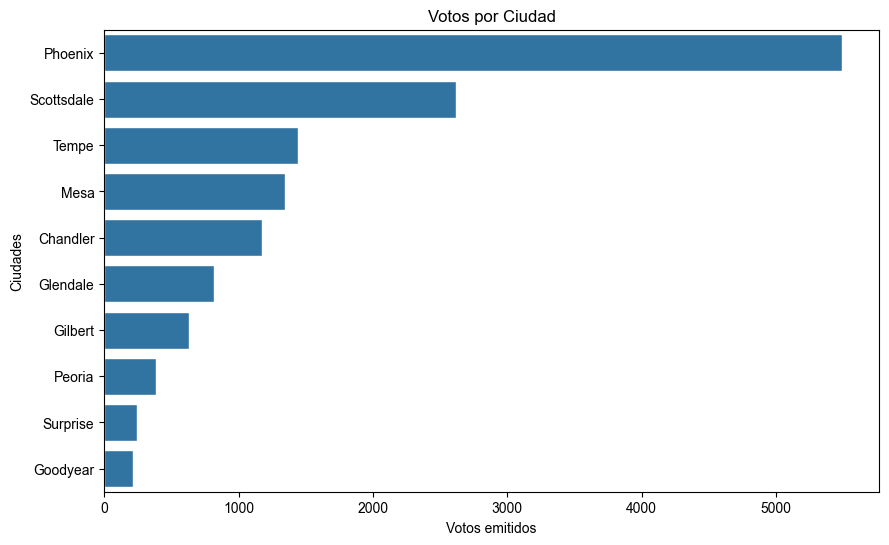

In [49]:
plt.figure(figsize=(10, 6))
plt.ticklabel_format(useOffset=False, style="plain")
sns.set_theme(style="whitegrid")
sns.barplot(x="votos", y="city", data=pdVC).set_title("Votos por Ciudad")
plt.xlabel("Votos emitidos")
plt.ylabel("Ciudades")

plt.show()

O por ejemplo, si queremos unir dos gráficos:

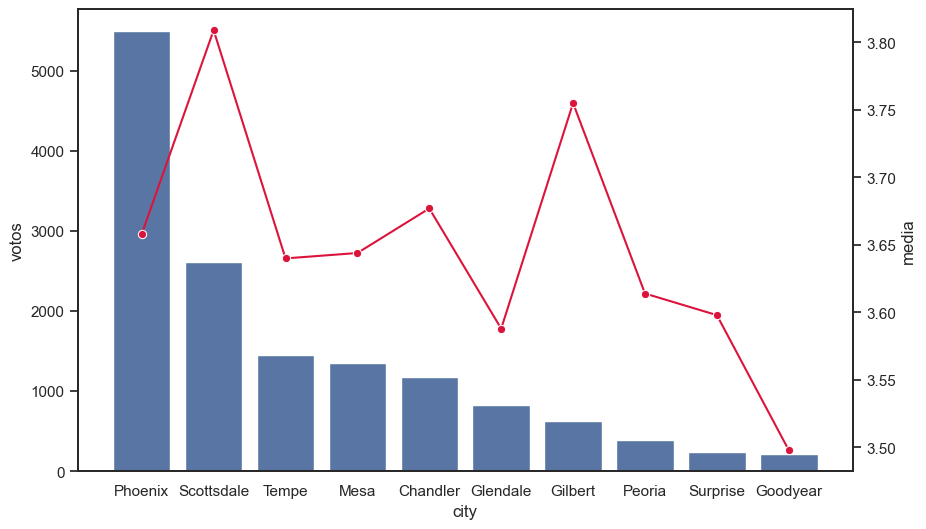

In [50]:
plt.figure(figsize=(10, 6))
sns.set_theme(style="white")
ax = sns.barplot(data=pdVC, y="votos", x="city")

ax2 = ax.twinx()
sns.lineplot(data=pdVC["media"], marker="o", color="crimson", ax=ax2)
plt.show()

 Hay que evitar Pandas para tratar los datos, ya que perdemos toda la potencia de trabajo en clúster (Pandas sólo puede utilizar los recursos del nodo principal). Únicamente lo utilizaremos cuando vayamos a visualizar los datos mediante Matplotlib / Seaborn como requisito de estas librerías.

### KOALAS
Desde la versión 3.2 de Spark, la librería de Koalas se ha integrado en Spark, dando lugar a poder utilizar el API de Pandas directamente desde Spark.

Para ello, únicamente hemos de importar la librería:

``````
import pyspark.pandas as ps
``````
Y acceder a ps de la misma manera que usamos pd al trabajar con Pandas.